In [1]:
import sys

import dgl
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import torch
import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

Using backend: pytorch


In [2]:
from cbbstats.data import columns
from cbbstats.data.graph_dataset import GraphDataset
from cbbstats.models.graph import GraphModel

In [5]:
train_df = pd.read_json('data/2011-2020_boxscores.json.gz')
val_df = pd.read_json('data/2021-2021_boxscores.json.gz')

In [7]:
train_df['HOME_AWAY']

0         H
1         H
2         H
3         A
4         H
         ..
113711    H
113712    A
113713    A
113714    H
113715    A
Name: HOME_AWAY, Length: 113716, dtype: object

In [4]:
train_ds = GraphDataset(train_df)
val_ds = GraphDataset(val_df, feature_scaler=train_ds.feature_scaler, target_scaler=train_ds.target_scaler)

train_dataloader = dgl.dataloading.GraphDataLoader(train_ds, batch_size=20)
val_dataloader = dgl.dataloading.GraphDataLoader(val_ds, batch_size=20)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 49.16it/s]


In [5]:
class NNModel(torch.nn.Module):
    def __init__(self, in_feat, hidden_feat):
        super().__init__()
        self.W1 = torch.nn.Linear(in_feat * 2 + 2, hidden_feat)
        self.W2 = torch.nn.Linear(hidden_feat, 1)
    
    def edge_to_node(self, graph, efeat):
        with graph.local_scope():
            graph.edata['h'] = efeat
            graph.update_all(
                message_func=dgl.function.copy_e('h', 'e'),
                reduce_func=dgl.function.mean('e', 'h')
            )
            return graph.ndata['h']
    
    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h'], edges.data['home']], 1)
        return {'pred': self.W2(torch.nn.functional.relu(self.W1(h)))}
    
    def pred(self, graph, nfeat):
        with graph.local_scope():
            graph.ndata['h'] = nfeat
            graph.apply_edges(self.apply_edges)
            return graph.edata['pred']

    def forward(self, graph, efeat, pgraph):
        node_hidden = self.edge_to_node(graph, efeat)
        return self.pred(pgraph, node_hidden)

In [6]:
class NaiveModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def edge_to_node(self, graph, efeat):
        with graph.local_scope():
            graph.edata['h'] = efeat
            graph.update_all(
                message_func=dgl.function.copy_e('h', 'e'),
                reduce_func=dgl.function.mean('e', 'h')
            )
            return graph.ndata['h']
    
    def pred(self, graph, nfeat):
        with graph.local_scope():
            graph.ndata['h'] = nfeat
            graph.apply_edges(dgl.function.v_sub_u('h', 'h', 'pred'))
            return graph.edata['pred']

    def forward(self, graph, efeat, pgraph):
        node_hidden = self.edge_to_node(graph, efeat)
        return self.pred(pgraph, node_hidden)

In [8]:
model = GraphModel(in_feat=36, hidden_feat=64, depth=5, dropout=0.1)
model.feature_scaler = train_ds.feature_scaler
model.target_scaler = train_ds.target_scaler

In [9]:
nn_model = NNModel(in_feat=36, hidden_feat=16)

In [10]:
naive_model = NaiveModel()

In [12]:
loss_fn = torch.nn.functional.smooth_l1_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
for epoch in range(epochs):
    model.train()
    tqdm_loader = tqdm.tqdm(train_dataloader, file=sys.stdout)
    epoch_loss = 0
    epoch_samples = 0
    for hgraph, pgraph in tqdm_loader:
        preds = model(hgraph, hgraph.edata['feat'], pgraph)
        loss = loss_fn(pgraph.edata['y'], preds)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_samples += 1
        tqdm_loader.set_description(f"Epoch {epoch + 1} Loss: {epoch_loss/epoch_samples:.4f}")
    
    model.eval()
    tqdm_loader = tqdm.tqdm(val_dataloader, file=sys.stdout)
    val_loss = 0
    val_samples = 0
    val_targets = []
    val_preds = []
    for hgraph, pgraph in tqdm_loader:
        preds = model(hgraph, hgraph.edata['feat'], pgraph)
        loss = loss_fn(pgraph.edata['y'], preds)
        val_targets.append(train_ds.target_scaler.inverse_transform(pgraph.edata['y'].detach().numpy()))
        val_preds.append(train_ds.target_scaler.inverse_transform(preds.detach().numpy()))
        val_loss += loss.item()
        val_samples += 1
        tqdm_loader.set_description(f"Validation Loss: {val_loss/val_samples:.4f}")
    val_targets = np.vstack(val_targets)
    val_preds = np.vstack(val_preds)
    val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    val_r2 = r2_score(val_targets, val_preds)
    print(f"Validation rmse: {val_rmse:.4f} r2: {val_r2:.4f}")

Epoch 1 Loss: 0.3866:   0%|                                                                                                     | 0/72 [00:00<?, ?it/s]

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Validation Loss: 0.3135: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]
Validation rmse: 12.3659 r2: 0.3219
Epoch 2 Loss: 0.3823:   0%|                                                                                                     | 0/72 [00:00<?, ?it/s]

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Validation Loss: 0.3168: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]
Validation rmse: 12.3668 r2: 0.3218
Epoch 3 Loss: 0.3841:   0%|                                                                                                     | 0/72 [00:00<?, ?it/s]

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Validation Loss: 0.3197: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.41it/s]
Validation rmse: 12.3760 r2: 0.3208
Epoch 4 Loss: 0.3783:   0%|                                                                                                     | 0/72 [00:00<?, ?it/s]

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Validation Loss: 0.3209: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]
Validation rmse: 12.3766 r2: 0.3207
Epoch 5 Loss: 0.3783:   0%|                                                                                                     | 0/72 [00:00<?, ?it/s]

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Validation Loss: 0.3174: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]
Validation rmse: 12.3879 r2: 0.3195


In [13]:
torch.save(model, 'models/graph.pt')

In [50]:
preds = []
targets = []
for hgraph, pgraph in val_ds:
    preds.append(train_ds.target_scaler.inverse_transform(model(hgraph, hgraph.edata['feat'], pgraph).detach().numpy()))
    targets.append(train_ds.target_scaler.inverse_transform(pgraph.edata['y'].detach().numpy()))

In [51]:
preds = np.vstack(preds).reshape(-1)
targets = np.vstack(targets).reshape(-1)

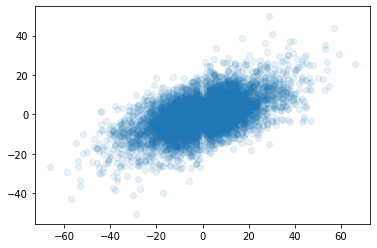

In [52]:
plt.scatter(targets, preds, alpha=0.1)
plt.show()

In [53]:
np.sqrt(mean_squared_error(targets, preds)), r2_score(targets, preds)

(12.442931, 0.3134043280052944)

In [54]:
(np.sign(preds) == np.sign(targets)).mean()

0.6767310204674118

In [29]:
preds = []
targets = []
for hgraph, pgraph in val_ds:
    preds.append(train_ds.target_scaler.inverse_transform(naive_model(hgraph, hgraph.edata['y'], pgraph).detach().numpy()))
    targets.append(train_ds.target_scaler.inverse_transform(pgraph.edata['y'].detach().numpy()))

In [30]:
preds = np.vstack(preds).reshape(-1)
targets = np.vstack(targets).reshape(-1)

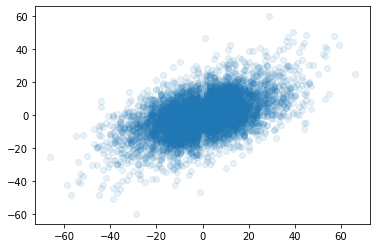

In [31]:
plt.scatter(targets, preds, alpha=0.1)
plt.show()

In [32]:
np.sqrt(mean_squared_error(targets, preds)), r2_score(targets, preds)

(13.316682, 0.2135924042560935)

In [33]:
(np.sign(preds) == np.sign(targets)).mean()

0.6546668602119321

In [40]:
loss_fn = torch.nn.functional.smooth_l1_loss
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    model.train()
    tqdm_loader = tqdm.tqdm(train_dataloader, file=sys.stdout)
    epoch_loss = 0
    epoch_samples = 0
    for hgraph, pgraph in tqdm_loader:
        preds = nn_model(hgraph, hgraph.edata['feat'], pgraph)
        loss = loss_fn(pgraph.edata['y'], preds)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_samples += 1
        tqdm_loader.set_description(f"Epoch {epoch + 1} Loss: {epoch_loss/epoch_samples:.4f}")
    
    model.eval()
    tqdm_loader = tqdm.tqdm(val_dataloader, file=sys.stdout)
    val_loss = 0
    val_samples = 0
    val_targets = []
    val_preds = []
    for hgraph, pgraph in tqdm_loader:
        preds = nn_model(hgraph, hgraph.edata['feat'], pgraph)
        loss = loss_fn(pgraph.edata['y'], preds)
        val_targets.append(train_ds.target_scaler.inverse_transform(pgraph.edata['y'].detach().numpy()))
        val_preds.append(train_ds.target_scaler.inverse_transform(preds.detach().numpy()))
        val_loss += loss.item()
        val_samples += 1
        tqdm_loader.set_description(f"Validation Loss: {val_loss/val_samples:.4f}")
    val_targets = np.vstack(val_targets)
    val_preds = np.vstack(val_preds)
    val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    val_r2 = r2_score(val_targets, val_preds)
    print(f"Validation rmse: {val_rmse:.4f} r2: {val_r2:.4f}")

Validation Loss: 0.3508: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 41.32it/s]
Validation rmse: 12.9487 r2: 0.2565
Validation Loss: 0.3433: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 60.38it/s]
Validation rmse: 12.7271 r2: 0.2817
Validation Loss: 0.3400: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 61.01it/s]
Validation rmse: 12.6332 r2: 0.2922
Validation Loss: 0.3391: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 61.76it/s]
Validation rmse: 12.6169 r2: 0.2941
Validation Loss: 0.3387: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 42.93it/s]
Validation rmse: 12.6157 r2: 0.2942
Validation Loss: 0.3377: 100%|███████████████████████████████████████████████████████

In [41]:
preds = []
targets = []
for hgraph, pgraph in val_ds:
    preds.append(train_ds.target_scaler.inverse_transform(nn_model(hgraph, hgraph.edata['feat'], pgraph).detach().numpy()))
    targets.append(train_ds.target_scaler.inverse_transform(pgraph.edata['y'].detach().numpy()))

In [42]:
preds = np.vstack(preds).reshape(-1)
targets = np.vstack(targets).reshape(-1)

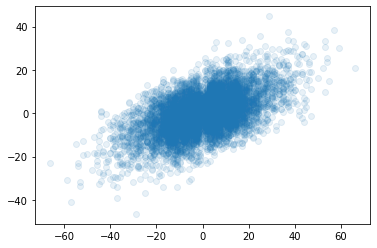

In [43]:
plt.scatter(targets, preds, alpha=0.1)
plt.show()

In [44]:
np.sqrt(mean_squared_error(targets, preds)), r2_score(targets, preds)

(12.583561, 0.2977968400763842)

In [45]:
(np.sign(preds) == np.sign(targets)).mean()

0.6745536362316736